# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm
import os
import random
import pickle
import warnings
import gc

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (precision_recall_curve, roc_curve, make_scorer, log_loss,
                             f1_score, confusion_matrix, auc, roc_auc_score, accuracy_score)

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

import optuna
from optuna.samplers import TPESampler

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
RANDOM_STATE = 4158
CHUNKSIZE = 50000

with open("../Data/dtypes.pkl", 'rb') as f:
    dtypes = pickle.load(f)

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
print(f"Using PyTorch version: {torch.__version__}, Device: {DEVICE}")
%matplotlib inline

Using PyTorch version: 1.12.1, Device: cuda


# def

In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(RANDOM_STATE)

In [3]:
def viewinfo(df:pd.DataFrame) -> None:
    print(df.shape)
    print()
    df.info()
    print()
    display(df.head())

In [4]:
print(dtypes)

{'loan_limit': 'uint64', 'loan_rate': 'float16', 'credit_score': 'uint16', 'yearly_income': 'uint64', 'income_type': 'uint8', 'employment_type': 'uint8', 'houseown_type': 'uint8', 'desired_amount': 'uint64', 'purpose': 'uint8', 'personal_rehabilitation_yn': 'bool', 'personal_rehabilitation_complete_yn': 'bool', 'existing_loan_cnt': 'uint16', 'existing_loan_amt': 'uint64', 'enter_birth': 'uint8', 'gender': 'bool', 'k_lending_rate': 'float16', 'us_lending_rate': 'float16', 'btc_price': 'uint32', 'btc_variance': 'float16', 'eth_price': 'uint32', 'eth_variance': 'float16', 'lunc_price': 'float32', 'lunc_variance': 'float16', 'Close': 'float16', 'Open': 'float16', 'High': 'float16', 'Low': 'float16', 'Volume': 'uint64', 'Change': 'float16', '실업자': 'uint16', '실업률': 'float16', '현재가계부채CSI': 'uint8', '가계부채전망CSI': 'uint8', '소비심리지수': 'float16', 'loanapply_insert_time_rank': 'uint8', 'loan_limit_avg_sub': 'float64', 'loan_rate_avg_sub': 'float16', 'bank_diversity': 'uint8', 'product_diversity': 'u

# Import Data

In [5]:
def loaddata(fname:str, chunksize:int, dtype:dict=None, columns:list=None):  
    df = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(fname, engine='python', low_memory=True, chunksize=chunksize, dtype=dtype)):
        df = pd.concat([df, chunk], axis=0)
        del chunk
        gc.collect()

    return df

In [6]:
train = loaddata("../Data/master_train_data.csv", chunksize=CHUNKSIZE, dtype=dtypes)
valid = loaddata("../Data/master_public_data.csv", chunksize=CHUNKSIZE, dtype=dtypes)

144it [05:44,  2.39s/it]
19it [00:40,  2.11s/it]


# Preprocessing

In [7]:
# train.drop('holiday', axis=1, inplace=True)
# valid.drop('holiday', axis=1, inplace=True)

In [8]:
cat_feats = ['income_type', 'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation_yn', 
             'personal_rehabilitation_complete_yn', 'gender', 'bank_diversity', 'product_diversity', 'holiday', 
             'weekday', 'foreign', 'segment', 'bank_label', 'product_label']
cat_idxs = [i for i, col in enumerate(train.columns.values) if col in cat_feats]

In [9]:
for col in train.columns.values:
    if train[col].dtype == 'bool':
        train[col] = train[col].astype('uint8')
    if valid[col].dtype == 'bool':
        valid[col] = valid[col].astype('uint8')

In [10]:
for col in cat_feats:
    if train[col].min() != 0:
        train[col] -= train[col].min()
    if valid[col].min() != 0:
        valid[col] -= valid[col].min()

In [11]:
cat_dims = [train[col].nunique() for col in cat_feats]

In [12]:
print(cat_idxs)
print(cat_dims)

[4, 5, 6, 8, 9, 10, 14, 37, 38, 43, 44, 50, 55, 63, 70]
[6, 4, 4, 8, 2, 2, 2, 56, 79, 2, 7, 2, 7, 3, 2]


# Evaluation Metric

In [13]:
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
    
    def __call__(self, y_true, y_score):
        y_score = (y_score[:, 1] > 0.5).astype(np.uint8)
        return f1_score(y_true, y_score)

# Pretraining

## Split X, y

In [14]:
X_train = train.drop('is_applied', axis=1)
y_train = train['is_applied']

X_valid = valid.drop('is_applied', axis=1)
y_valid = valid['is_applied']

In [15]:
print(f"Unique categories")
for col in cat_feats:
    print(f"\ttrain {col} -> {np.sort(X_train[col].unique())}", end='')
    print(f"\tvalid {col} -> {np.sort(X_valid[col].unique())}")

Unique categories
	train income_type -> [0 1 2 3 4 5]	valid income_type -> [0 1 2 3 4 5]
	train employment_type -> [0 1 2 3]	valid employment_type -> [0 1 2 3]
	train houseown_type -> [0 1 2 3]	valid houseown_type -> [0 1 2 3]
	train purpose -> [0 1 2 3 4 5 6 7]	valid purpose -> [0 1 2 3 4 5 6 7]
	train personal_rehabilitation_yn -> [0 1]	valid personal_rehabilitation_yn -> [0 1]
	train personal_rehabilitation_complete_yn -> [0 1]	valid personal_rehabilitation_complete_yn -> [0 1]
	train gender -> [0 1]	valid gender -> [0 1]
	train bank_diversity -> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]	valid bank_diversity -> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
	train product_diversity -> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15

## Hyper-parameters

In [16]:
## constant values for hyper-parameter
BATCH_SIZE = 2**10
GHOST_BATCH = 2**7
MAX_EPOCH = 100
N_STEPS = 5
LR = 25e-3
PATIENCE = 5
PRETRAINING_RATIO = 0.8
NROWS = 1

## Pretrain model

In [17]:
tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_fn=torch.optim.Adam, 
    optimizer_params=dict(lr=LR), 
    mask_type="entmax", # another option: sparsemax
    n_steps=N_STEPS,  #0.2,
    seed=RANDOM_STATE,
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device_name=str(DEVICE)
)

pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(X_train=X_train.values, 
               eval_set=[X_valid.values], 
               max_epochs=MAX_EPOCH, 
               patience=PATIENCE, 
               batch_size=BATCH_SIZE, 
               virtual_batch_size=GHOST_BATCH, #128, 
               num_workers=0, 
               drop_last=False,
               pretraining_ratio=PRETRAINING_RATIO)

Device used : cuda
epoch 0  | loss: 3533750.3352| val_0_unsup_loss: 52.7593 |  0:09:19s
epoch 1  | loss: 3225250.2597| val_0_unsup_loss: 48.9266 |  0:19:11s
epoch 2  | loss: 1767855.59079| val_0_unsup_loss: 34.08615|  0:29:06s
epoch 3  | loss: 1194257.70816| val_0_unsup_loss: 3.8127  |  0:39:01s
epoch 4  | loss: 834809.48502| val_0_unsup_loss: 5.25513 |  0:48:58s
epoch 5  | loss: 497444.9859| val_0_unsup_loss: 6.60558 |  0:58:55s
epoch 6  | loss: 413945.50996| val_0_unsup_loss: 3.94301 |  1:08:50s
epoch 7  | loss: 353732.08801| val_0_unsup_loss: 15.24597|  1:18:45s
epoch 8  | loss: 278217.24758| val_0_unsup_loss: 5.2388  |  1:28:39s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_unsup_loss = 3.8127
Best weights from best epoch are automatically used!


## Plot Results

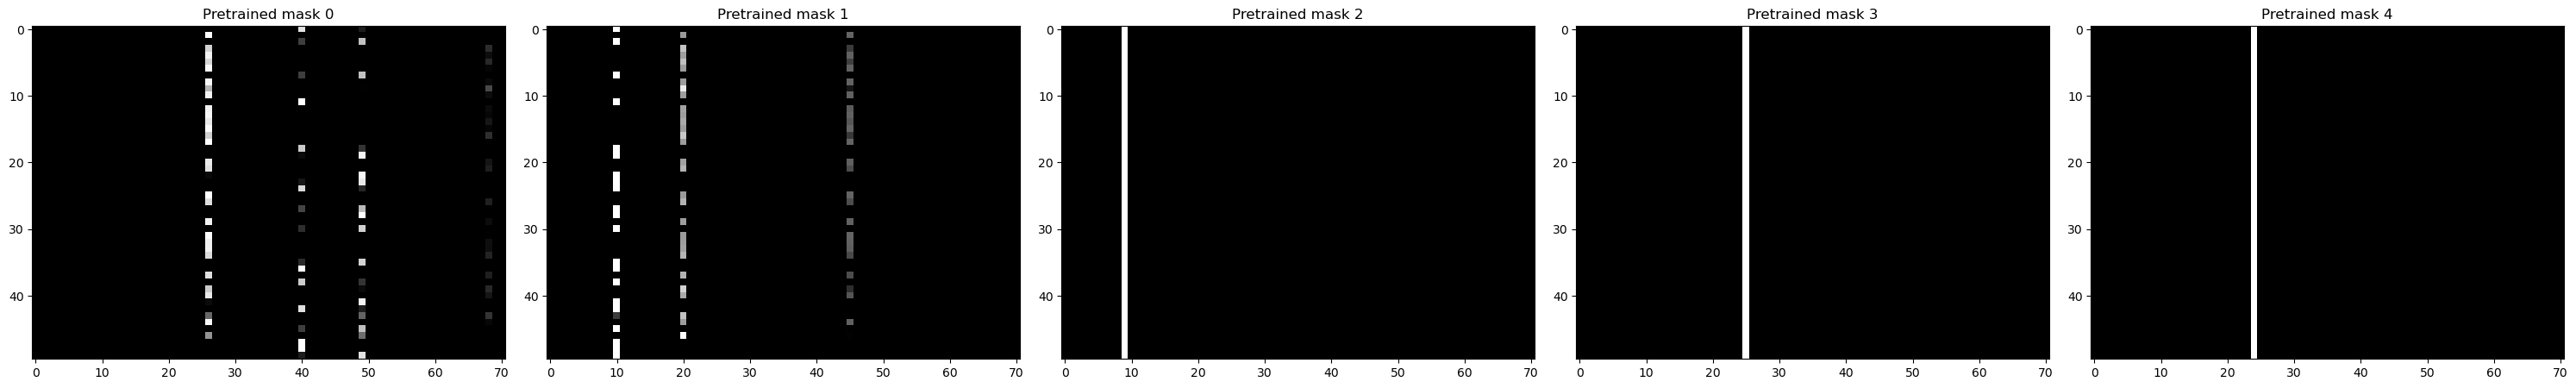

In [18]:
pretrain_explain_matrix, pretrain_masks = pretrainer.explain(valid.values)

plt.figure(figsize=(30, 10))
for key in pretrain_masks:
    plt.subplot(int(f"{NROWS}{N_STEPS//NROWS}{key+1}"))
    plt.imshow(pretrain_masks[key][:50], cmap='gray')
    plt.title(f"Pretrained mask {key}")
plt.tight_layout()
plt.show()

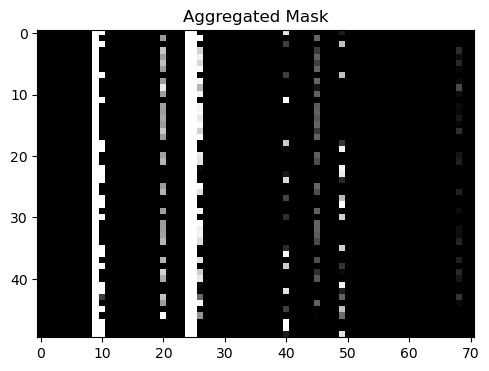

In [19]:
mask_agg = np.zeros(shape=pretrain_masks[0].shape)
for key in pretrain_masks:
    mask_agg += pretrain_masks[key]
mask_agg /= len(pretrain_masks)

plt.figure(figsize=(5, 10))
plt.imshow(mask_agg[:50], cmap='gray')
plt.title(f"Aggregated Mask")
plt.tight_layout()
plt.show()

In [20]:
del pretrain_explain_matrix, pretrain_masks, mask_agg
gc.collect()

17633

## Save Model

In [21]:
with open("../Model/pretrainer_no_sampling.pkl", 'wb') as f:
    pickle.dump(pretrainer, f, protocol=pickle.HIGHEST_PROTOCOL)

# Supervised Learning

In [28]:
clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_fn=torch.optim.Adam, 
    optimizer_params=dict(lr=LR), 
    mask_type="entmax", # another option: sparsemax
    n_steps=N_STEPS,  #0.2,
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device_name=str(DEVICE)
)

Device used : cuda


In [ ]:
clf.fit(
    X_train=X_train.values, 
    y_train=y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss', 'f1'],
    max_epochs=MAX_EPOCH, 
    patience=8,
    batch_size=BATCH_SIZE, 
    virtual_batch_size=GHOST_BATCH,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=pretrainer
) 

Loading weights from unsupervised pretraining


In [ ]:
try:
    clf.save_model(f"../Model/clf_no_sampling")
except:
    with open(f"../Model/clf_no_sampling.pkl", 'wb') as f:
        pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)